<a href="https://colab.research.google.com/github/lamaachi/MyDataScience_Projects/blob/main/Deep_Learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the main directory for the dataset
directory = '/content/drive/MyDrive/Colab Notebooks/datasets/The IQ-OTHNCCD lung cancer dataset'

In [21]:
!ls '/content/drive/MyDrive/Colab Notebooks/datasets/The IQ-OTHNCCD lung cancer dataset'

'Bengin cases'	'Malignant cases'  'Normal cases'


In [ ]:
import os
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:

# List of categories and their respective names
categories = ["Bengin cases", "Malignant cases", "Normal cases"]

# Define the standard image size for all images
img_size = 256
# Initialize lists to store image data and corresponding labels

data = []
labels = []

# Read images from the corresponding folders
for category in categories:
    # Correctly join the path without duplicating the category name
    path = os.path.join(directory, category)
    # print(f"Looking in: {path}")  # Debug statement to confirm the path
    class_num = categories.index(category)  # Assign a numeric label for each category

    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        # print(f"Processing file: {filepath}")  # Debug statement
        try:
            # Read the image in grayscale
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize the image to a fixed size
            img_resized = cv2.resize(img, (img_size, img_size))

            # Append the resized image and its label to the lists
            data.append(img_resized)
            labels.append(class_num)
        except Exception as e:
            # Handle any error that occurs during image processing
            print(f"Error processing file {filepath}: {e}")
print("Processing completed.")


Processing completed.


In [ ]:
print("Balanced Dataset Summary:")
print(f"Total images: {len(data)}")
for i, category in enumerate(categories):
    print(f"Number of images in '{category}': {labels.count(i)}")
print(f"Image shape: {data[0].shape}")

Balanced Dataset Summary:
Total images: 1097
Number of images in 'Bengin cases': 120
Number of images in 'Malignant cases': 561
Number of images in 'Normal cases': 416
Image shape: (256, 256)


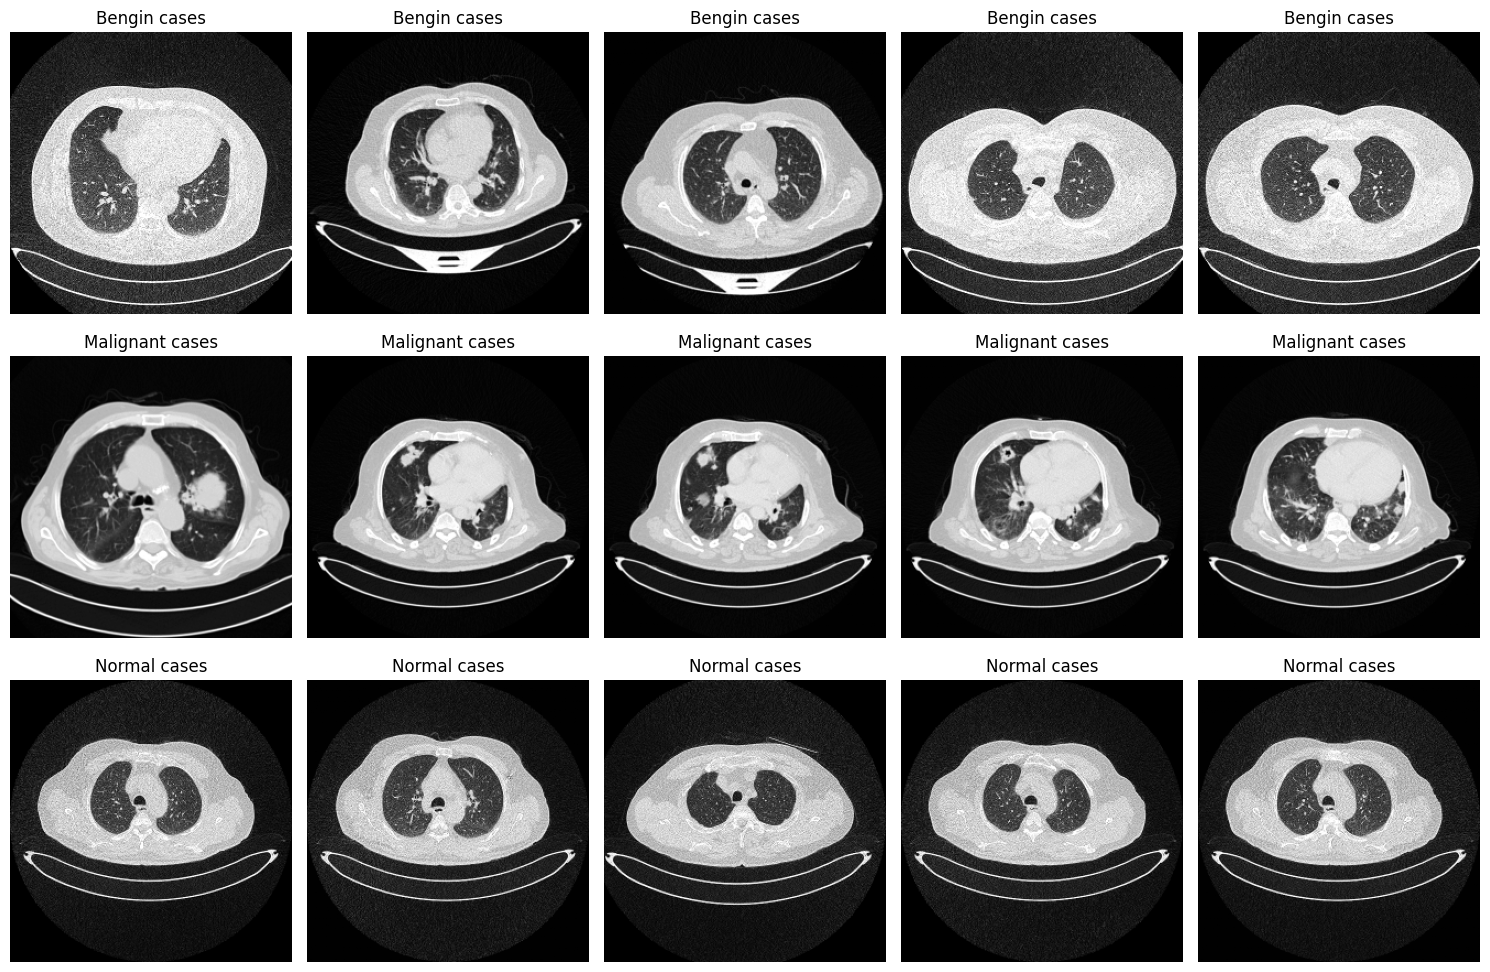

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few sample images from each category
fig, axes = plt.subplots(len(categories), 5, figsize=(15, 10))
for i, category in enumerate(categories):
    idx = np.where(labels == i)[0][:5]  # Select first 5 images from each category
    for j, ax in enumerate(axes[i]):
        ax.imshow(data[idx[j]].reshape(img_size, img_size), cmap='gray')
        ax.axis('off')
        ax.set_title(category)
plt.tight_layout()
plt.show()

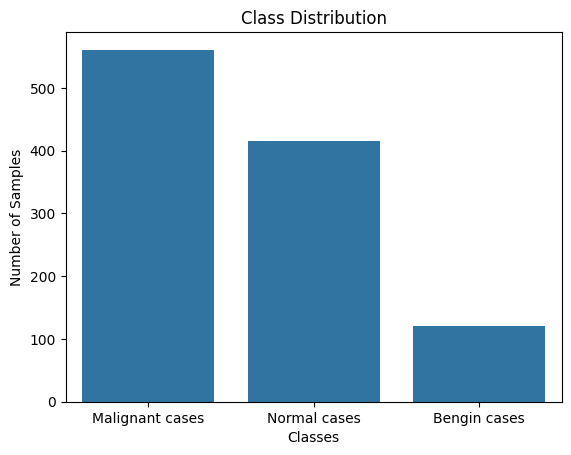

In [ ]:
import pandas as pd
import seaborn as sns

# Count occurrences of each label
label_counts = pd.Series(labels).value_counts()
label_names = [categories[i] for i in label_counts.index]

# Plot class distribution
sns.barplot(x=label_names, y=label_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Classes")
plt.show()

Mean pixel value: 104.60
Standard deviation of pixel values: 76.46


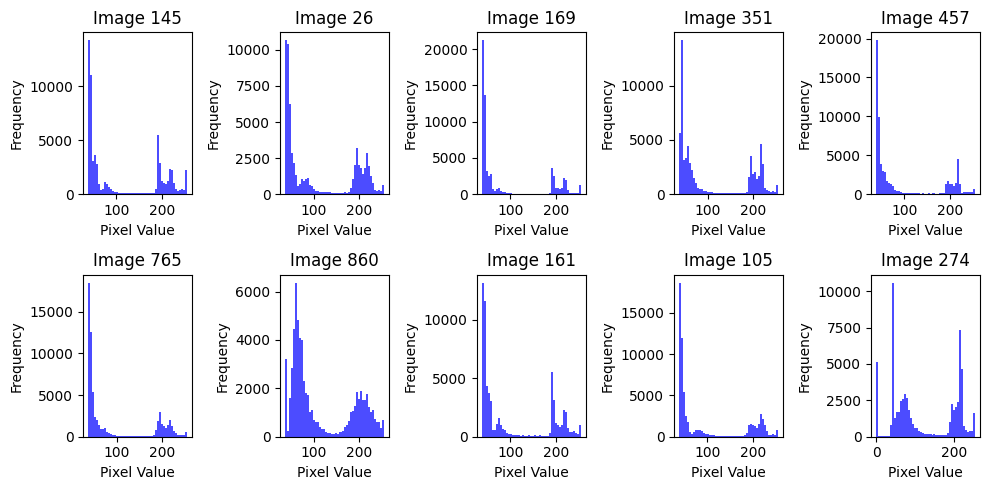

In [ ]:
# Calculate mean and standard deviation
mean_pixel = np.mean(data)
std_pixel = np.std(data)
print(f"Mean pixel value: {mean_pixel:.2f}")
print(f"Standard deviation of pixel values: {std_pixel:.2f}")

# Plot pixel value distribution for a random sample of images
random_idx = np.random.choice(len(data), 10, replace=False)
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_idx):
    plt.subplot(2, 5, i+1)
    plt.hist(data[idx].ravel(), bins=50, color='blue', alpha=0.7)
    plt.title(f"Image {idx}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


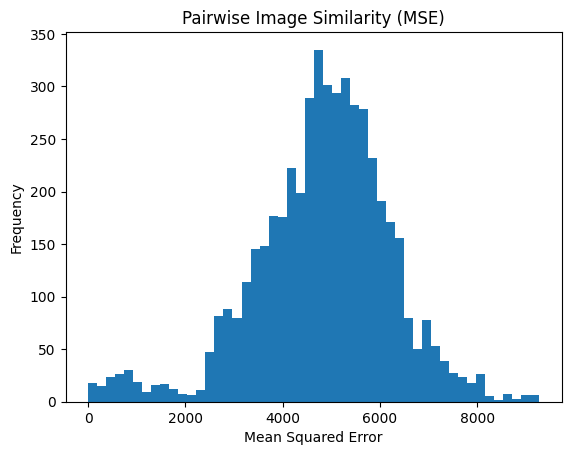

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate pairwise similarity for the first 100 images
similarities = []
for i in range(100):
    for j in range(i+1, 100):
        mse = mean_squared_error(data[i].ravel(), data[j].ravel())
        similarities.append(mse)

# Visualize similarity distribution
plt.hist(similarities, bins=50)
plt.title("Pairwise Image Similarity (MSE)")
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Convert the data list to a NumPy array
data = np.array(data)  # No reshaping needed as image size is already firmed
# Normalize pixel values to the range [0, 1] and reshape the data for model input
data = data.reshape(-1, img_size, img_size, 1) / 255
labels = np.array(labels)

In [ ]:

# Split the dataset into training (80%) and testing (20%) sets initially
x_temp, x_test, y_temp, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Further split the remaining 80% into training (70%) and validation (10%) sets
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# تحويل الصور الرمادية إلى ثلاث قنوات مرة واحدة فقط
x_train = np.repeat(x_train, 3, axis=-1)  # تحويل بيانات التدريب إلى ثلاث قنوات
x_valid = np.repeat(x_valid, 3, axis=-1)  # تحويل بيانات التحقق إلى ثلاث قنوات
x_test = np.repeat(x_test, 3, axis=-1)    # تحويل بيانات الاختبار إلى ثلاث قنوات

In [22]:
# Apply SMOTE for data augmentation
from imblearn.over_sampling import SMOTE

In [ ]:
# إعداد الطبقة الأساسية EfficientNetV2-S
base_model = EfficientNetV2S(
    include_top=False,  # استبعاد الطبقة النهائية
    weights='imagenet',  # استخدام الأوزان المدربة مسبقًا
    input_shape=(img_size, img_size, 3)  # ضبط شكل الإدخال (صور بثلاث قنوات)
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# البناء العلوي للنموذج
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output_layer = Dense(3, activation='softmax')(x)  # تصنيف 3 فئات

# بناء النموذج النهائي
model = Model(inputs=base_model.input, outputs=output_layer)

# تثبيت الطبقات الأساسية للتدريب الأولي
base_model.trainable = False

# تجميع النموذج
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# عرض ملخص النموذج
# model.summary()

# استدعاءات التدريب
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

In [ ]:
# تدريب النموذج
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=25,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4903 - loss: 0.9906 - val_accuracy: 0.7364 - val_loss: 0.8596
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.5927 - loss: 0.8799 - val_accuracy: 0.7636 - val_loss: 0.8010
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6400 - loss: 0.8236 - val_accuracy: 0.7273 - val_loss: 0.7739
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.6088 - loss: 0.8407 - val_accuracy: 0.7182 - val_loss: 0.7553
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.6483 - loss: 0.8142 - val_accuracy: 0.7273 - val_loss: 0.7392
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.6312 - loss: 0.8183 - val_accuracy: 0.7273 - val_loss: 0.7340
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6396 - loss: 0.8288 - val_accuracy: 0.7364 - val_loss: 0.7167
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.6469 - loss: 0.8067 - val_accuracy: 0.7

In [ ]:
# إلغاء تثبيت الطبقات الأساسية للتدريب الكامل
base_model.trainable = True

# إعادة تجميع النموذج بمعدل تعلم أقل
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# إعادة تدريب النموذج
history_fine_tune = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=25,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.7525 - loss: 0.5862 - val_accuracy: 0.5455 - val_loss: 1.0119
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 374ms/step - accuracy: 0.9594 - loss: 0.1444 - val_accuracy: 0.7000 - val_loss: 0.7868
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 595ms/step - accuracy: 0.9584 - loss: 0.1335 - val_accuracy: 0.9273 - val_loss: 0.2433
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 524ms/step - accuracy: 0.9973 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 0.0299
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.9942 - loss: 0.0219 - val_accuracy: 0.9545 - val_loss: 0.0911
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.9953 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 392ms/step - accuracy: 0.9981 - loss: 0.0158 - val_accuracy: 0.9909 - val_loss: 0.0301
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 496ms/step - accuracy: 0.9991 - loss: 0.0092 - val_accura

In [ ]:
# تقييم النموذج على بيانات الاختبار
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9678 - loss: 0.1189
Test Accuracy: 0.97
